In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [ ]:
# Load the data
data = pd.read_csv('Organized_Data.csv')
data.set_index('Datetime', inplace=True)

In [ ]:
# Handle missing values by dropping them
data = data.dropna().reset_index(drop=True)

# Suppress the first values (false numbering of people)
data = data.dropna()
data = data[180:].reset_index()

In [ ]:
# Separate features and target variable
X = data.drop(columns=['nb_persons_SH'])
y = data['nb_persons_SH']

In [ ]:
# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
Xcnn = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Reshape the data for 1D CNN (samples, timesteps, features)
Xcnn_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
Xcnn_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))

In [ ]:
# # Split the data into training and validation sets
# Xcnn_train, Xcnn_valid, ycnn_train, ycnn_valid = train_test_split(Xcnn, y, test_size=0.2, random_state=42)

# CNN Classification of nb of people

In [ ]:
# Convert target variable to categorical
from tensorflow.keras.utils import to_categorical
unique_classes = np.unique(np.concatenate([y_train, y_valid]))
num_classes = len(unique_classes)
y_train = to_categorical(y_train, num_classes=int(y.max() + 1))
y_valid = to_categorical(y_valid, num_classes=int(y.max() + 1))
print(unique_classes)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras import regularizers

In [ ]:
model_CNN_classification_1 = Sequential([
    Conv1D(12, 2, activation='relu', input_shape=(Xcnn_train.shape[1], 1), padding='same'),
    MaxPooling1D(2),
    Conv1D(64, 2, activation='relu', padding='same'), 
    MaxPooling1D(2),
    Conv1D(128, 2, activation='relu', padding='same'), 
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(int(y.max() + 1), activation='softmax')
])

model_CNN_classification_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model_CNN_classification_1.fit(Xcnn_train, y_train, epochs=250, batch_size=32, validation_data=(Xcnn_valid, y_valid))

# Evaluate the model
loss, accuracy = model_CNN_classification_1.evaluate(Xcnn_valid, y_valid)
print(f'Validation accuracy: {accuracy:.4f}')

In [ ]:
model_CNN_classification_2 = Sequential([
    Conv1D(12, 3, activation='relu', input_shape=(Xcnn_train.shape[1], 1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.2),

    Conv1D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.2),

    Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(int(y.max() + 1), activation='softmax')
])

model_CNN_classification_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
# model_CNN_classification_2.fit(Xcnn_train, y_train, epochs=250, batch_size=64, validation_data=(Xcnn_valid, y_valid))

# Evaluate the model
loss, accuracy = model_CNN_classification_2.evaluate(Xcnn_valid, y_valid)
print(f'Validation accuracy: {accuracy:.4f}')

# Saving the CNN Classification Models

In [ ]:
# Save the entire model to a keras file
# model.save('AI models/1DCNN_Odlmodel.keras')
# model2.save('AI models/1DCNN_Newmodel.keras')

# LSTM Classification

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
# Load the data
data = pd.read_csv('Organized_Data.csv', parse_dates=['Datetime'])
data.set_index('Datetime', inplace=True)

In [ ]:
data = data.dropna()
data = data[180:]

In [ ]:
# Extract features and labels
X = data.drop(columns=['nb_persons_SH'])
y = data['nb_persons_SH']

In [ ]:
split_index = int(len(X) * 0.9)
X_train, X_valid = X[:split_index], X[split_index:]
y_train, y_valid = y[:split_index], y[split_index:]

## Create sequential data


In [ ]:
# Define sequence length
sequence_length = 10

# Normalize/Standardize data
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_valid = (X_valid - np.mean(X_valid, axis=0)) / np.std(X_valid, axis=0)

# Verify unique class values in y_train and y_valid
unique_classes = np.unique(np.concatenate([y_train, y_valid]))
num_classes = len(unique_classes)

# Function to create overlapping sequences
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# Create sequences
X_train_sequences = create_sequences(X_train, sequence_length)
X_valid_sequences = create_sequences(X_valid, sequence_length)

# Create corresponding target values (using the last value in each sequence)
y_train_sequences = y_train[sequence_length - 1:]
y_valid_sequences = y_valid[sequence_length - 1:]

# Convert target values to categorical for multiclass classification
y_train_sequences = to_categorical(y_train_sequences, num_classes=num_classes)
y_valid_sequences = to_categorical(y_valid_sequences, num_classes=num_classes)

In [ ]:
model = Sequential([
    Input(shape=(sequence_length, X_train.shape[1])),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(128)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output layer for multiclass classification
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# # Early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train_sequences, y_train_sequences, 
          epochs=500, validation_data=(X_valid_sequences, y_valid_sequences), 
          batch_size=32)#, callbacks=[early_stopping])

# Verifications

In [ ]:
import seaborn as sns

In [ ]:
CNN1predictions = model_CNN_classification_1.predict(Xcnn)
CNN1predicted_classes = np.argmax(predictions, axis=1)
CNN1true_classes = np.argmax(y_valid_sequences, axis=1)

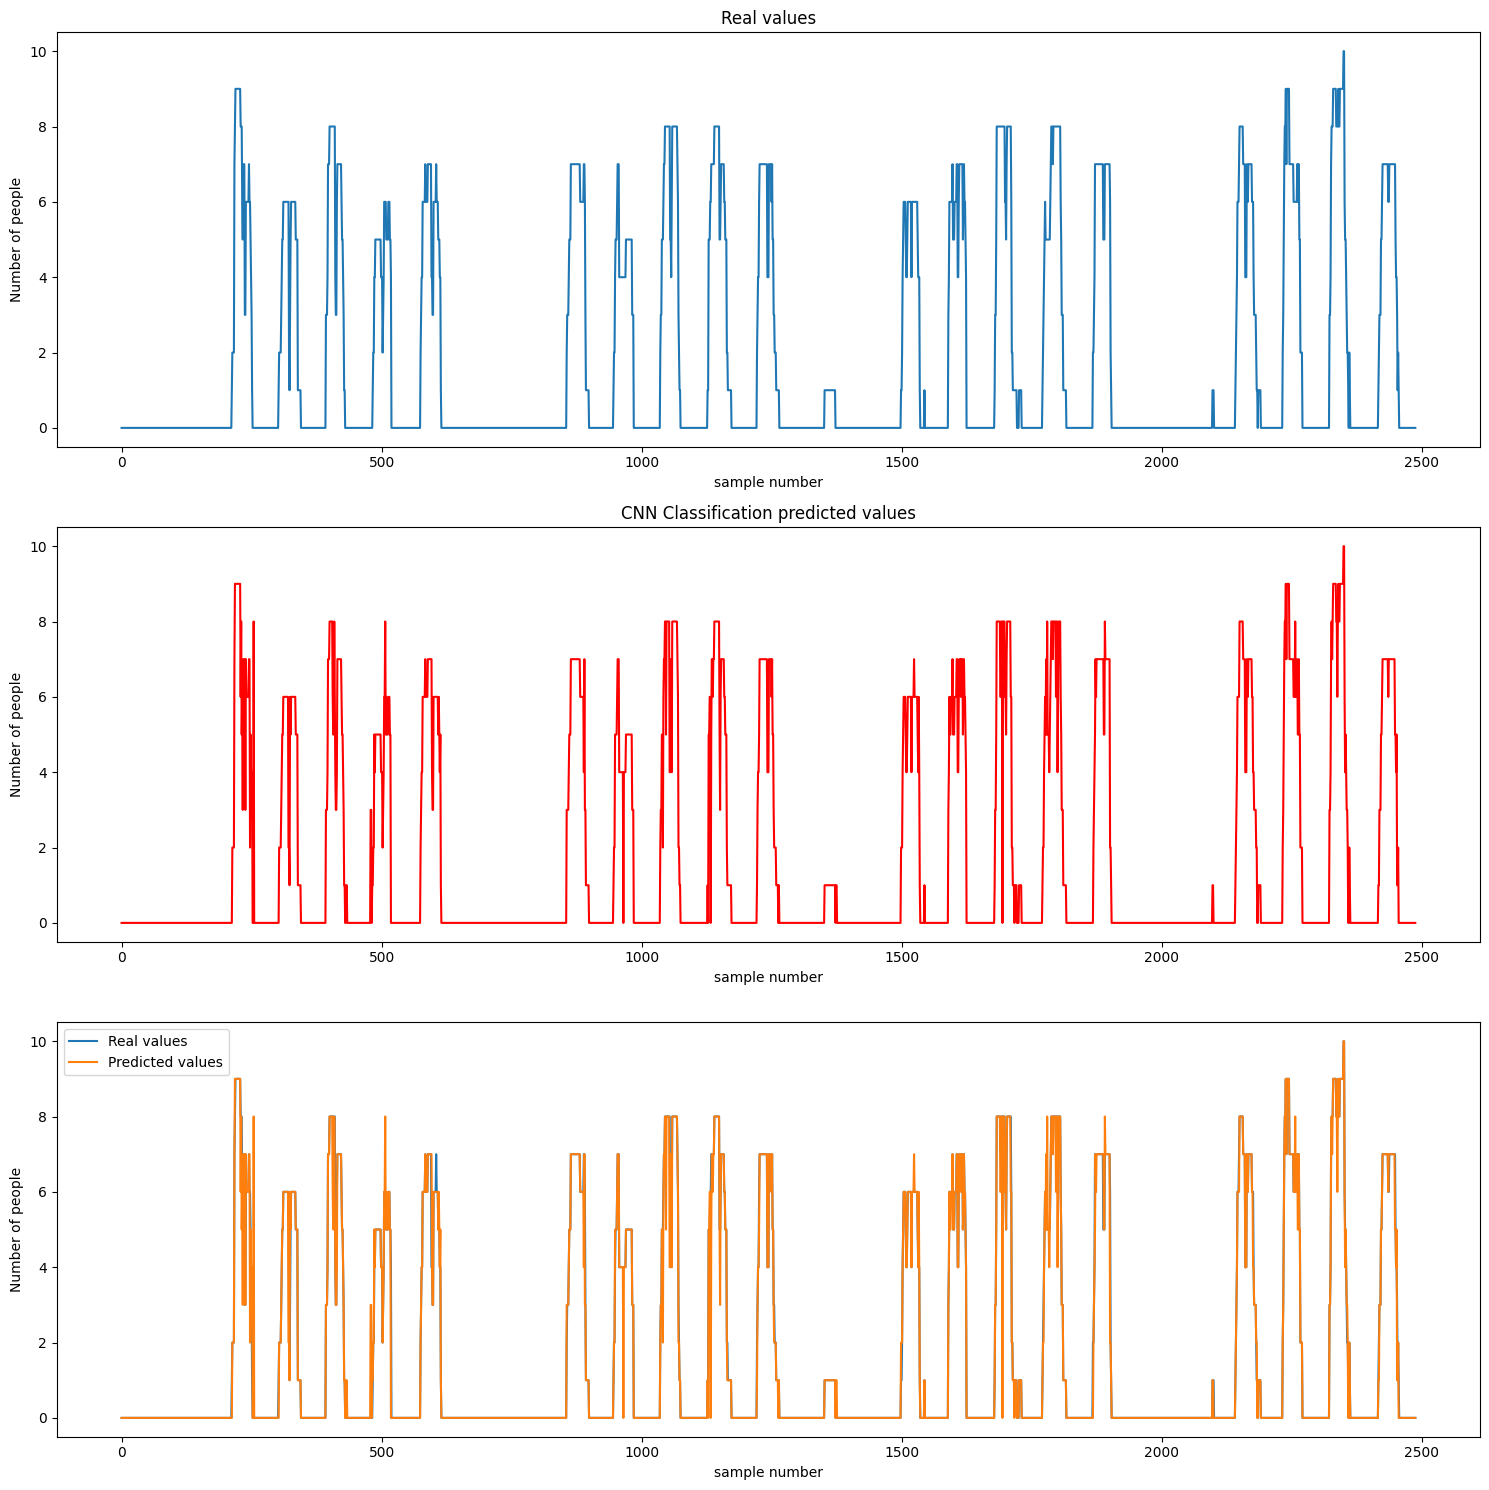

In [161]:
#plot figures:
plt.figure(figsize=(15,15))
plt.subplot(3, 1, 1)
plt.plot(y)
plt.title('Real values')
plt.xlabel('sample number')
plt.ylabel('Number of people')

plt.subplot(3, 1, 2)
plt.plot(CNN1predicted_classes,color='r')
plt.title('CNN Classification predicted values')
plt.xlabel('sample number')
plt.ylabel('Number of people')

plt.subplot(3, 1, 3)
sns.lineplot(data=y, label='Real values')
sns.lineplot(data=CNN1predicted_classes, label='Predicted values')
plt.xlabel('sample number')
plt.ylabel('Number of people')
plt.legend()

plt.tight_layout()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


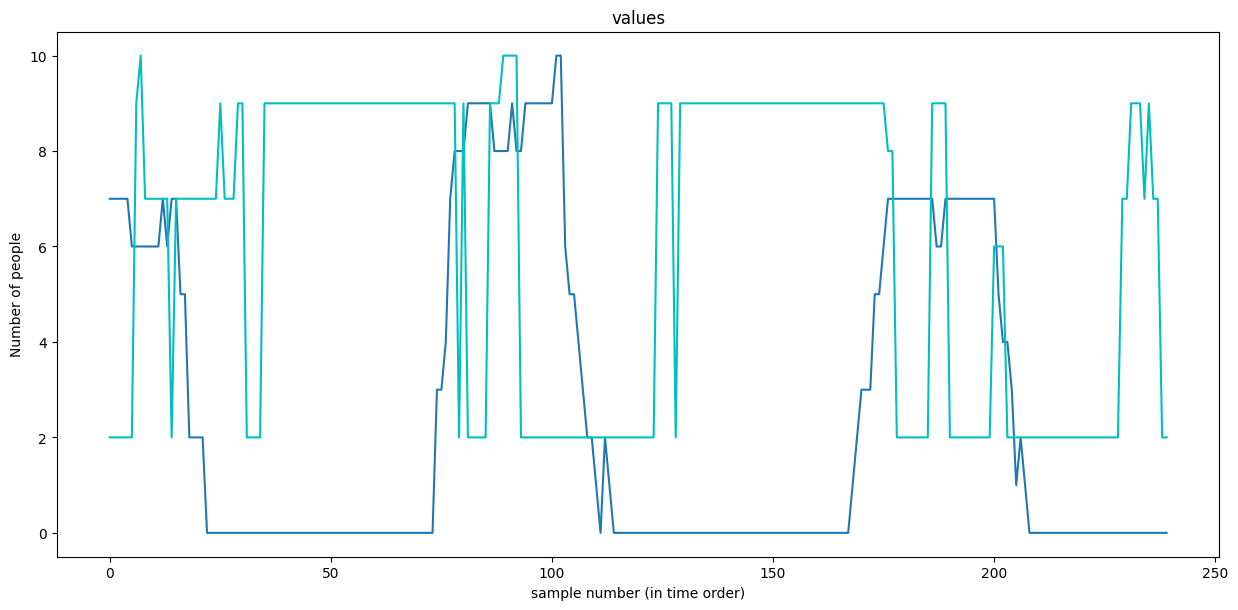

In [162]:
predictions = model_LSTM_classification.predict(X_valid_sequences)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_valid_sequences, axis=1)

#plot figures:
plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.plot(true_classes)
plt.plot(predicted_classes,color='c')
plt.title('values')
plt.xlabel('sample number (in time order)')
plt.ylabel('Number of people')
"real values"
"predicted values"
plt.show()